In [45]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



### Geometric and statistical skews on a real-world dataset

The code below demonstrates the effects of geometric and statistical skews in a real-world linearly separable dataset 
sourced from the UCI ML repository. Please refer to this link for the original dataset: https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

In [ ]:


import tensorflow as tf
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import cvxpy as cp
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras import backend as K
from keras.models import Model
import numpy as np
import cvxpy as cp

colors = ['black','#377eb8', '#ff7f00', '#4daf4a',
              '#984ea3', '#a65628', '#f781bf',
              '#999999', '#e41a1c', '#dede00']
markers = [ 'h', '*', '<', 'o', 's', 'v', 'D' ]
local_dir = '/home/jupyter'

plot_dir = f'{local_dir}/plot_pdfs'




In [2]:
np.random.seed(seed=42)

# Data preprocessing

Here, we'll load the data, shuffle it, convert it to a binary classification task and rescale the features. As such the data is originally a 6-class classification task with labels in {0,1,2...,6}. 
But we'll  {0,1,2} as class 1 and {4,5,6} as class 2. We'll ignore datapoints with original label = 3 to create sufficient gap between the two classes.

In the following code, we'll also set `spur_ind`, the index of the spurious feature (you can play around with different choices for this).

In [3]:
# Load and shuffle data
data = np.loadtxt('third_party/obesity_dataset/ObesityDataSet.csv',skiprows=1,delimiter=',') 
np.random.shuffle(data)

spur_ind = 18 # The 18th column inthe data corresponds to the "spurious feature"
label_ind = 20 # The 20th column corresponds to the label

#==================
# Conversion to binary classification task:
#==================

data = data[np.logical_or.reduce([data[:,label_ind] == x for x in [0,1,2,4,5,6]]),:] 
print(f"{data.shape[0]} datapoints remain.")
# Convert these labels to 0 and 1.
data[data[:,label_ind]<=3, label_ind] = 0
data[data[:,label_ind]>=4, label_ind] = 1
print(f"Labels have been simplified to {np.unique(data[:,label_ind])}")
labels = data[:,-1]
data = data[:,:-1]
# Rescale the data
#data = preprocessing.scale(data)
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)
# num_data = data.shape[0]

# Create test-train split
num_data = data.shape[0]
x_train, y_train = data[:int(0.6*num_data)], labels[:int(0.6*num_data)]
x_test, y_test = data[int(0.6*num_data):], labels[int(0.6*num_data):]

1821 datapoints remain.
Labels have been simplified to [0. 1.]


Next, we'll create partitions of the test data depending on whether the spurious feature equals the label or not. 

In [4]:
# Determine which indices in the training set correspond to x_sp = y and x_sp != y
pos_train_ind = (x_train[:,spur_ind] == y_train)
neg_train_ind = (x_train[:,spur_ind] != y_train)

# Determine which indices in the test set correspond to x_sp = y and x_sp != y
pos_test_ind = (x_test[:,spur_ind] == y_test)
neg_test_ind = (x_test[:,spur_ind] != y_test)

# Select datapoints in the training set where x_sp = y and x_sp != y
pos_x_train, pos_y_train = x_train[pos_train_ind], y_train[pos_train_ind]
neg_x_train, neg_y_train = x_train[neg_train_ind], y_train[neg_train_ind]

# Select datapoints in the test set where x_sp = y and x_sp != y
pos_x_test, pos_y_test = x_test[pos_test_ind], y_test[pos_test_ind]
neg_x_test, neg_y_test = x_test[neg_test_ind], y_test[neg_test_ind]

print(f'Num training data where x_sp = y: {pos_x_train.shape[0]}')
print(f'Num training data where x_sp = y: {neg_x_train.shape[0]}')
print(f'Num test data where x_sp = y: {pos_x_test.shape[0]}')
print(f'Num test data where x_sp = y: {neg_x_test.shape[0]}')

Num training data where x_sp = y: 581
Num training data where x_sp = y: 511
Num test data where x_sp = y: 395
Num test data where x_sp = y: 334


As such there is a small level of spurious correlation here (i.e., x_sp _is_ spuriously correlated with y), but as we'll see this is
not significant enough to cause trouble.

# Geometric skews

Recall from the paper that our investigation of geometric skews relies on studying the max-margin classifier. Let's setup the function required for computing that. 

### Functions to compute max-margin and its error

In [5]:
def fit_max_margin(x_train, y_train):
    """
    Returns max-margin solution on the training datapoint
    # Arguments:
        x_train (np.array): training inputs
        y_train (np.array): 0/1 training labels
    # Returns
        weights (np.array): array of weights
        bias (float): bias value
    """
    
    # One could also use scipy to do this but  
    # with the following code there's greater flexibility to play around with the
    # constraints and see how things change
    
    x_train = x_train.reshape((x_train.shape[0],-1))
    A = np.hstack([x_train,np.ones((x_train.shape[0],1))]) # Append a "1" for the bias feature
    Ide = np.identity(x_train.shape[1])
    b_ones = np.ones(A.shape[0])
    cp_weights = cp.Variable(A.shape[1])
    
    # Quadratic program corresponding to minimizing ||w||^2
    # subject to y (x^T w) >= 1
    prob = cp.Problem(cp.Minimize(cp.quad_form(cp_weights[:-1], Ide)),
                         [np.diag(2*y_train-1) @ ((A @ cp_weights)) >= b_ones])
    prob.solve(verbose=False, solver=cp.ECOS)
    weights = cp_weights.value
    return weights[:-1], weights[-1]

def evaluate_max_margin(x_test, y_test, weights, bias):
    """
    Returns accuracy of a linear classifier on test data
    # Arguments:
        x_test (np.array): test inputs
        y_test (np.array): 0/1 test labels 
        weights, bias (np.array, float): weights and bias
    # Returns
        accuracy: accuracy of the weights on the given test data
    """
    x_test = x_test.reshape((x_test.shape[0],-1))
    margins = np.matmul(x_test, weights) + bias
    accuracy = np.mean(np.multiply(margins, 2*y_test - 1) > 0.0)
    return accuracy

### Max-margin classifier on the original dataset

Let us first look at what the max-margin classifier looks like in the "original" data. Later on, we'll modify the dataset to induce a spurious correlation, and then look at the max-margin classifier on that new dataset. 


In [6]:
mm_weights, mm_bias = fit_max_margin(x_train,y_train)
# If you want to look at how much weight the classifier assigns to different weights, plot this.
#plt.bar(np.arange(mm_weights.shape[0]),np.abs(mm_weights))
#plt.xticks(np.arange(mm_weights.shape[0]));
accuracy = evaluate_max_margin(x_test, y_test, mm_weights, mm_bias)
print(f"Test accuracy = {accuracy}")

Test accuracy = 1.0


Let us see how well this classifier performs on the "majority" data where `x_sp = y` and the "minority" data where `x_sp !=y`. 

In [7]:
pos_accuracy = evaluate_max_margin(pos_x_test, pos_y_test, mm_weights, mm_bias)
print(f"Majority test accuracy = {pos_accuracy}")
neg_accuracy = evaluate_max_margin(neg_x_test, neg_y_test, mm_weights, mm_bias)
print(f"Minority test accuracy = {neg_accuracy}")

Majority test accuracy = 1.0
Minority test accuracy = 1.0


Since there is not much difference in the proportion of majority and minority data in this dataset, the max-margin classifier fares equally well on both groups!
Let's also make note of how much weight this gives to the spurious feature on this dataset without a spurious correlation

In [8]:
(mm_weights[spur_ind])/np.linalg.norm(mm_weights)

0.008574459603720577

### Max-margin classifier on dataset with spurious correlation

Now, let's create a new dataset which is a subset of the above dataset, but with many of the minority points ignored. This creates a dataset where `x_sp` is highly correlated with `y`.



In [9]:
factor = 50 # The factor by which we want to reduce the size of the minority datapoints
print(f"Size of new majority group = {pos_x_train.shape[0]}")
print(f"Size of new minority group = {int(neg_x_train.shape[0]/factor)}")

geom_skewed_x_train = np.vstack([pos_x_train, neg_x_train[:int(neg_x_train.shape[0]/factor)]])
geom_skewed_y_train = np.concatenate([pos_y_train, neg_y_train[:int(neg_y_train.shape[0]/factor)]])


Size of new majority group = 581
Size of new minority group = 10


Let's train a max-margin classifier on this dataset and observe its performance on the test majority and test minority groups.

In [11]:
skewed_mm_weights, skewed_mm_bias = fit_max_margin(geom_skewed_x_train,geom_skewed_y_train)
pos_accuracy = evaluate_max_margin(pos_x_test, pos_y_test, skewed_mm_weights, skewed_mm_bias)
print(f"Majority test accuracy = {pos_accuracy}")
neg_accuracy = evaluate_max_margin(neg_x_test, neg_y_test, skewed_mm_weights, skewed_mm_bias)
print(f"Minority test accuracy = {neg_accuracy}")

Majority test accuracy = 0.9949367088607595
Minority test accuracy = 0.5718562874251497


The classifier has worse performance on the minority group, implying that it has positively weighted the spurious feature. As before, let us also look at the exact weight assigned to the spurious feature. 

In [12]:
skewed_mm_weights[spur_ind]/np.linalg.norm(skewed_mm_weights)

0.12401697156704843

### Max-margin norm vs training set size

Our fundamental premise behind why the max-margin classifier uses the weakly predictive spurious feature was that, in the invariant feature space, the l2 norm of the max-margin classifier increases with the training set size. Let's check if this is true for this dataset.

In [13]:
n_train_list = [4,8,16,32,64,128,256,512,1024] # Varying number of training dataset sizes.
norms = []
for n_train in n_train_list:
    norms += [[]]
    for k in range(5):
        inds = np.random.choice(np.arange(x_train.shape[0]), n_train,replace=False) # Randomly select
        # subset of data
        
        # Fit max-margin on the subset of the data, but only after removing the spurious feature
        temp_mm_weights, temp_mm_bias = fit_max_margin(np.delete(x_train[inds], spur_ind, axis=1),y_train[inds])
        norms[-1] += [np.linalg.norm(temp_mm_weights)]
        
ys = [np.mean(y) for y in norms]
yerrs = [np.std(y) for y in norms] # Error bars


<Figure size 360x360 with 0 Axes>

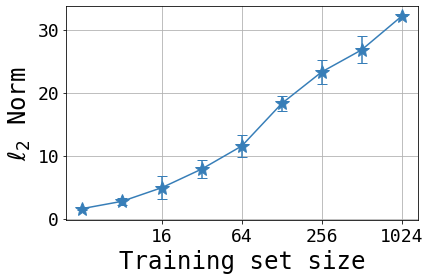

In [43]:
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Training set size',fontsize=24)
ax.set_ylabel(r'$\ell_2$ Norm',fontsize=24)
ax.errorbar(x=np.log(n_train_list),y=ys,yerr= yerrs,marker=markers[1], color=colors[1], 
            capsize=5,markersize=15)
ax.grid()
plt.tight_layout()
plt.xticks(np.log([16,64,256,1024]), ['16','64','256','1024']);
plt.savefig(f'obesity_geom_skew.pdf')


## Statistical skews

Next let's understand how the spurious correlation affects gradient descent. 

### Functions to train w/ gradient descent

In [18]:
from keras.layers import Input, Flatten, Dense, Activation

def linear_classifier(input_shape,  use_bias = True):
    """Linear classifier and its logit output
    # Arguments
        input_shape (tensor): shape of input image tensor
        use_bias (boolean): use bias variable or not
    # Returns
        model (Model): Keras model instance
        logits (Model): Keras model instance for the logit layer
    """
    inputs = Input(shape=input_shape)
    x = Dense(1,kernel_initializer='zeros', use_bias = use_bias)(inputs)
    logits = Model(inputs=inputs, outputs=x)
    outputs = Activation('sigmoid')(x)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model, logits

In [19]:
from keras.optimizers import SGD
from keras.losses import BinaryCrossentropy


# The following callback allows us to store and access weights
# throughout training
from keras.callbacks import Callback
class SaveWeights(Callback):
    def __init__(self, verbose=0):
        super(SaveWeights, self).__init__()
        self.epoch = []
        self.history = {}

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        self.history.setdefault("Weights", []).append(self.model.layers[1].get_weights())




Now, we'll create datasets with statistical skews by merely duplicating points in the group `x_sp = y`. By doing so, we'll create datasets with levels of spurious correlation varying from 0.5 to 0.75 to 0.99. We'll then train with SGD with learning rate 0.01.


In [39]:
n_epochs = 10000
n_train = 500 # Number of training points we want in the new dataset 
spur_p_list= [0.75,0.85] # List of spurious correlation values
# for each value we'll consider a different dataset with that level of spurious correlation
# i.e., Pr[x_sp  = y]

# In all the following lists, there'll be one entry corresponding to each of the datasets 
# that we create.
histories = []
callback_list = []
# The following are for weights and biases of the max-margin trained on these datasets
stat_skewed_mm_weights_list = [] 
stat_skewed_mm_bias_list = []
for p in spur_p_list:
    # Create a statistically skewed training dataset with spurious correlation level = p
    n_pos = int(n_train*p)  # Number of points in the x_sp = y group (majority)
    n_neg = int(n_train*(1-p))# Number of points in the x_sp != y group (minority)
    
    # We'll create the new "duplicated "majority group (ofsize n_pos) by picking n_neg 
    # unique points from it and then duplicating it (n_pos/n_neg) times
    stat_skewed_x_train = np.vstack([pos_x_train[:n_neg] for i in range(int(n_pos/n_neg))]+ 
                                [neg_x_train[:n_neg]])
    stat_skewed_y_train = np.concatenate([pos_y_train[:n_neg] for i in range(int(n_pos/n_neg))]+ 
                                [neg_y_train[:n_neg]])
    print(f"Num points = {stat_skewed_x_train.shape[0]}")

    
    model, _ = linear_classifier(input_shape=x_train.shape[1:])
    loss = BinaryCrossentropy(from_logits=False)
    model.compile(loss=loss,
                        optimizer=SGD(learning_rate=0.01),
                        metrics=['accuracy'])
    callbacks = [SaveWeights()]
    history = model.fit(stat_skewed_x_train, stat_skewed_y_train,
                  batch_size=32,
                  epochs=n_epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True, workers=4,
                  callbacks=callbacks,verbose=0)
    histories += [history]
    callback_list += [callbacks[0]]
    
    # Learn the max-margin classifier on this dataset and store it in a list
    stat_skewed_mm_weights, stat_skewed_mm_bias = fit_max_margin(stat_skewed_x_train,stat_skewed_y_train)
    stat_skewed_mm_weights_list += [stat_skewed_mm_weights]
    stat_skewed_mm_bias_list += [stat_skewed_mm_bias]

Num points = 500
Num points = 450


Now let's plot how the weight assigned to the spurious feature evolves over time. First we need to do a little bit of work to gather these weights from the callbacks:

In [40]:

spur_weights_list = [] # Each entry in this list will correspond
# to one of the spurious correlation levels
for callback in callback_list:
    # Each loop corresponds to training on a particular level of spurious correlation
    spur_weights = [] # This will be a list of scalar values equal to w_sp(t)/||w(t)||
    for weights in callback.history['Weights']:
        spur_weights +=  [np.abs(weights[0][spur_ind])/np.linalg.norm(weights[0])]
    spur_weights= np.array(spur_weights)
    spur_weights_list += [spur_weights]

<Figure size 360x360 with 0 Axes>

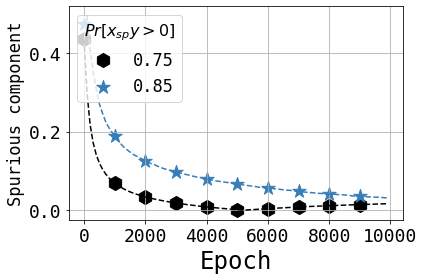

In [42]:
# Plotting function
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Epoch',fontsize=24)
ax.set_ylabel('Spurious component',fontsize=17)

for k in [0,1]:
    inds = np.arange(0,n_epochs,100)
    ax.plot(inds,spur_weights_list[k][inds],
                        linestyle = '--',color=colors[k])
    inds = np.arange(0,n_epochs,1000)
    ax.scatter(inds,spur_weights_list[k][inds],marker=markers[k], 
                       color=colors[k],s=200,label=f'{spur_p_list[k]}')

legend = plt.legend(fontsize=17, ncol=1, loc='upper left',title=r'$Pr[x_{sp}y > 0]$')
plt.setp(legend.get_title(),fontsize='16')
ax.grid()
#plt.ylim([0,1])
plt.tight_layout()


What happens to the max-margin classifier in these settings? The above datasets have roughly the same number of unique datapoints in both the majority and minority group. So we'd expect the max-margin classifier to not assign much weight to the spurious feature in all of these datasets. Let's verify that by looking at its error on the two groups and weight assigned to the spurious component.

In [44]:
for k in range(len(spur_p_list)):
    print(f"Spurious correlation = {spur_p_list[k]}")
    pos_accuracy = evaluate_max_margin(pos_x_test, pos_y_test, 
                                       stat_skewed_mm_weights_list[k], stat_skewed_mm_bias_list[k])
    print(f"Majority test accuracy = {pos_accuracy}")
    neg_accuracy = evaluate_max_margin(neg_x_test, neg_y_test, 
                                       stat_skewed_mm_weights_list[k], stat_skewed_mm_bias_list[k])
    print(f"Minority test accuracy = {neg_accuracy}")
    print(f"Spurious component = {stat_skewed_mm_weights_list[k][spur_ind]/np.linalg.norm(stat_skewed_mm_weights_list[k])}")

Spurious correlation = 0.75
Majority test accuracy = 0.9873417721518988
Minority test accuracy = 0.9970059880239521
Spurious component = 0.009504891436380685
Spurious correlation = 0.85
Majority test accuracy = 0.9518987341772152
Minority test accuracy = 0.9670658682634731
Spurious component = -0.035519159153161804
